# Exp4: 基于K-近邻的车牌号识别

## 一、案例简介

图像的智能处理一直是人工智能领域广受关注的一类技术，代表性的如人脸识别与 CT 肿瘤识别，在人工智能落地的进程中发挥着重要作用。其中车牌号识别作为一个早期应用场景，已经融入日常生活中，为我们提供了诸多便利，在各地的停车场和出入口都能看到它的身影。车牌号识别往往分为字符划分和字符识别两个子任务，本案例我们将关注字符识别的任务，尝试用 K-NN 的方法对分割好的字符图像进行自动识别和转化。

## 二、作业说明

### 基本要求
* 完成数据的读入和表示，将图片表示成向量并和 label 对应上；
* 构建 K-NN 模型（可调库）对测试集中的图片进行预测并计算准确率；
* 分析当 K 取不同值时测试准确率的变化。

### 扩展要求
* 分析不同距离度量方式对模型效果的影响；
* 对比平权和加权 K-NN 的效果；
* 分析训练集大小对测试结果的影响。

## 三、数据概览
本次我们使用已经分割好的车牌图片作为数据集，包括数字 0-9、字母 A-Z（不包含 O 和 I）以及省份简称共 65 个类，编号从 0 到 64。数据已经分成了训练集和测试集，里面的文件夹用 label 编号命名，一个文件夹下的所有图片都属于该文件夹对应的类，每个图片都是 20 * 20 的二值化灰度图。

下面演示一下如何借助 PIL 库将图片转化为向量：

In [39]:
from PIL import Image
img = Image.open('data/train/0/4-3.jpg')  # 打开图片
img  # 显示图片from PIL import Image
img = Image.open('data/train/0/4-3.jpg')  # 打开图片
img  # 显示图片

In [40]:
import numpy as np
pixels = np.array(img)  # 转化为 numpy 矩阵
pixels.shape

(20, 20)

## 四、模型构建

### 1. 读入数据、向量表示、对应label

In [41]:
import pandas as pd
import os

def load_data(path):
    result = []
    for label in os.listdir(path):
        if not os.path.isdir(os.path.join(path, label)):
            continue
        for file in os.listdir(os.path.join(path, label)):
            if file.endswith('.jpg'):
                result.append([label, np.array(Image.open(os.path.join(path, label, file)))])
    return pd.DataFrame(result, columns=['label', 'file'])

train_data = load_data('data/train')
test_data = load_data('data/test')

### 2. 构建KNN模型

In [42]:
print(train_data.head())
print(test_data.head())

  label                                               file
0     0  [[1, 0, 1, 0, 0, 2, 26, 139, 254, 255, 254, 25...
1     0  [[0, 2, 0, 0, 5, 0, 0, 22, 247, 255, 255, 249,...
2     0  [[0, 3, 0, 0, 4, 0, 1, 58, 217, 255, 251, 217,...
3     0  [[3, 0, 0, 3, 3, 0, 2, 14, 187, 253, 255, 187,...
4     0  [[0, 0, 1, 0, 2, 1, 0, 15, 23, 26, 233, 25, 26...
  label                                               file
0     0  [[0, 0, 0, 0, 0, 0, 6, 30, 64, 80, 78, 75, 69,...
1     0  [[0, 2, 0, 2, 1, 1, 0, 2, 0, 0, 1, 0, 2, 2, 0,...
2     0  [[0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2, 1, 0, 0,...
3     0  [[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,...
4     0  [[0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0,...


In [43]:
train_data['flatten_file'] = train_data.file.map(lambda file: file.flatten())
test_data['flatten_file'] = test_data.file.map(lambda file: file.flatten())
print(train_data.head())
print(test_data.head())

  label                                               file  \
0     0  [[1, 0, 1, 0, 0, 2, 26, 139, 254, 255, 254, 25...   
1     0  [[0, 2, 0, 0, 5, 0, 0, 22, 247, 255, 255, 249,...   
2     0  [[0, 3, 0, 0, 4, 0, 1, 58, 217, 255, 251, 217,...   
3     0  [[3, 0, 0, 3, 3, 0, 2, 14, 187, 253, 255, 187,...   
4     0  [[0, 0, 1, 0, 2, 1, 0, 15, 23, 26, 233, 25, 26...   

                                        flatten_file  
0  [1, 0, 1, 0, 0, 2, 26, 139, 254, 255, 254, 254...  
1  [0, 2, 0, 0, 5, 0, 0, 22, 247, 255, 255, 249, ...  
2  [0, 3, 0, 0, 4, 0, 1, 58, 217, 255, 251, 217, ...  
3  [3, 0, 0, 3, 3, 0, 2, 14, 187, 253, 255, 187, ...  
4  [0, 0, 1, 0, 2, 1, 0, 15, 23, 26, 233, 25, 26,...  
  label                                               file  \
0     0  [[0, 0, 0, 0, 0, 0, 6, 30, 64, 80, 78, 75, 69,...   
1     0  [[0, 2, 0, 2, 1, 1, 0, 2, 0, 0, 1, 0, 2, 2, 0,...   
2     0  [[0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2, 1, 0, 0,...   
3     0  [[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 准备数据
X_train = np.stack(train_data.flatten_file.values)
y_train = train_data.label.values
X_test = np.stack(test_data.flatten_file.values) 
y_test = test_data.label.values

def test_knn(k=1):
    # 训练模型
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # 预测
    y_pred = knn.predict(X_test)  # 现在使用正确的X_test

    # 评估
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [45]:
print(f"k=3, accuracy={test_knn(3)}")

k=3, accuracy=0.7031082529474812


In [46]:
statistics = [[k, test_knn(k)] for k in range(1, 10)]

In [47]:
df = pd.DataFrame(statistics, columns=['k','accuracy'])

<Axes: xlabel='k'>

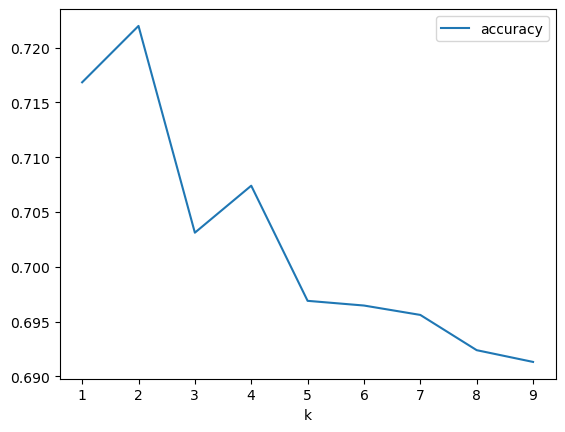

In [48]:
df.plot(x='k', y='accuracy')

## 五、实验报告

### 1. k取不同值时准确率的变化

看实验结果图中，当k在1~9中随着k值增大，准确率整体趋势下降。当k=2时取到最大值。

### 2. 实验总结

1. knn 训练时，需要的数据是数组。通过PIL Image读取出来后是 ndarray of ndarray of uint8。需要通过flatten将结果转换为1维数组。
2. knn 方法是一个基于实例的方法，不同于线性回归、决策树等通过权重来存储学习，而是将整个样本实例保存下来，通过对比新样本与历史样本的距离关系来决定最终的标签。
3. knn 是一种lazy learner，而需要预先训练数据的比如线性回归之类的属于eager learner。
4. knn 方法中一个关键的数据结构是KD-Tree。如果需要将所有样本实例保存下来，必须提供一个快速比较距离的方法，KD-Tree有点类似于二叉搜索树的多维版本，这种结构就提供了快速查询较近距离的样本